In [ ]:
print("retest")

# FOLD = '/content/'
FOLD = '/kaggle/working/'
import os

In [4]:
import shutil

# Function to remove a folder and its contents
def remove_folder(path):
    try:
        shutil.rmtree(path)
        print(f"Folder {path} and its contents successfully removed.")
    except OSError as e:
        print(f"Error: {e.strerror}")

# Specify the path of the folder to be removed
folder_path = os.path.join(FOLD, 'dataset')

# Call the function to remove the folder
remove_folder(folder_path)

Folder /kaggle/working/dataset and its contents successfully removed.


In [5]:
!git clone https://github.com/QuanHoangNgoc/Container.git dataset

Cloning into 'dataset'...
remote: Enumerating objects: 6739, done.
remote: Total 6739 (delta 0), reused 0 (delta 0), pack-reused 6739
Receiving objects: 100% (6739/6739), 140.80 MiB | 45.63 MiB/s, done.
Updating files: 100% (7024/7024), done.


In [18]:
!git clone https://github.com/QuanHoangNgoc/Figshare_Dataset local_dataset

Cloning into 'local_dataset'...
remote: Enumerating objects: 3071, done.
remote: Total 3071 (delta 0), reused 0 (delta 0), pack-reused 3071
Receiving objects: 100% (3071/3071), 838.49 MiB | 27.86 MiB/s, done.
Updating files: 100% (3067/3067), done.


In [20]:
MAT_DATA = FOLD + '/local_dataset/dataset/data'
print("mat data: ", MAT_DATA) 

mat data:  /kaggle/working//local_dataset/dataset/data


# Try examples

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
import random
import numpy as np

# Define Deep Q Network (DQN)
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define a combined TD(0) Q-learning with DQN training function
def td_dqn(env, num_episodes=1000, batch_size=32, target_update=10, gamma=0.99, learning_rate=0.001, epsilon=0.1):
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    policy_net = DQN(state_size, action_size)
    target_net = DQN(state_size, action_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    replay_memory = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            with torch.no_grad():
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    q_values = policy_net(torch.tensor(state, dtype=torch.float32))
                    action = torch.argmax(q_values).item()

            next_state, reward, done, _ = env.step(action)

            replay_memory.append((state, action, reward, next_state, done))

            if len(replay_memory) >= batch_size:
                batch = random.sample(replay_memory, batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)

                states = torch.tensor(states, dtype=torch.float32)
                actions = torch.tensor(actions)
                rewards = torch.tensor(rewards, dtype=torch.float32)
                next_states = torch.tensor(next_states, dtype=torch.float32)
                dones = torch.tensor(dones, dtype=torch.float32)

                current_q_values = policy_net(states).gather(1, actions.unsqueeze(1))
                next_q_values = target_net(next_states).max(1)[0].detach()
                target_q_values = rewards + gamma * next_q_values * (1 - dones)

                loss = criterion(current_q_values, target_q_values.unsqueeze(1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

    return policy_net

# Main part: using CartPole-v1 environment
env = gym.make("CartPole-v1")
trained_dqn = td_dqn(env, num_episodes=1000, batch_size=32, target_update=10, gamma=0.99, learning_rate=0.001, epsilon=0.1)
print(trained_dqn)

In [ ]:
def evaluate_model(env, model, num_episodes=100):
    total_rewards = []
    for _ in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            q_values = model(torch.tensor(state, dtype=torch.float32))
            action = torch.argmax(q_values).item()
            next_state, reward, done, _ = env.step(action)
            state = next_state
            episode_reward += reward
        total_rewards.append(episode_reward)
    average_reward = np.mean(total_rewards)
    return average_reward

# Evaluate the trained DQN model
average_reward = evaluate_model(env, trained_dqn, num_episodes=100)
print(f"Average reward over 100 episodes: {average_reward}")

# "Source Code"

## --Const

In [6]:
######################################################################################
# Const
######################################################################################
CLEAR_LOG = True  # clear file log (if need)
example_code = True


SIZE = (256, 256)
TYPE = 'COLOR'
VALUE = [0, 255]

In [7]:
######################################################################################
# Set Up
######################################################################################
import skimage as ski
import keras
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
# import Const
import math

if (example_code):
    print("ski version: ", ski.__version__)
    print("keras version: ", keras.__version__)
    print("numpy version: ", np.__version__)
    print("pandas version: ", pd.__version__)
    print("sklearn version: ", skl.__version__)


ski version:  0.22.0
keras version:  3.2.1
numpy version:  1.26.4
pandas version:  2.2.2
sklearn version:  1.2.2


In [8]:
######################################################################################
# Utils
######################################################################################
import logging
from absl import logging as absl_logging
from skimage import io, exposure
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
# from SetUp import *
import inspect


######################################################################################################
# NORMAL UTIL
######################################################################################################
def get_current_method_name(index=2):
    current_frame = inspect.stack()[index]
    method_name = current_frame.function
    return "<" + method_name + ">"


NUM_PRT_SC = int(1e18)


def setup_logging():
    # Set the log file path
    _log_file = os.path.join(os.getcwd(), '_log')
    if not os.path.exists(_log_file):
        os.makedirs(_log_file)
    _log_file = os.path.join(_log_file, 'log.txt')
    if (CLEAR_LOG and os.path.exists(_log_file)):
        os.remove(_log_file)

    # format = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
    # Configure the Python logging to write to the log file
    logging.basicConfig(filename=_log_file, level=logging.INFO, format=None)
    # Redirect absl logging to the Python logging
    absl_logging.use_python_logging()
    absl_logging.info("\n\n")


setup_logging()


class ut:
    _active = True

    def __init__(self):
        pass

    def act(active):
        ut._active = active
        global NUM_PRT_SC
        if NUM_PRT_SC > 2:
            NUM_PRT_SC = 2
        else:
            NUM_PRT_SC = int(1e18)

    def prt_section():
        global NUM_PRT_SC
        if NUM_PRT_SC < 1:
            return
        else:
            NUM_PRT_SC -= 1
        logging.info("~" * int(77 * 1))
        print("~" * int(77 * 1), flush=True)

    def mess(*mess):
        if ut._active == False:
            return
        ut.prt_section()
        out = '# '
        func_dir = get_current_method_name()
        if (func_dir not in ['<over>', '<note_verbose>']):
            out += get_current_method_name() + "\n"

        for arg in mess:
            out += str(arg) + " "
        global absl_logging
        absl_logging.info(out)
        print(out, flush=True)
        ut.prt_section()

    def note_verbose(flag, title):
        if ut._active == False:
            return
        func_dir = get_current_method_name()
        # ut.prt_section()
        ut.mess("__verbose__:", func_dir, "\n", "@@@", title)
        # ut.prt_section()

    def over(val, var_name=None):
        if ut._active == False:
            return
        if var_name == None:
            var_name = "{}".format(get_current_method_name())
        else:
            var_name = "{1} \n [{0}]".format(var_name,
                                             get_current_method_name())
        # ut.prt_section()
        try:
            ratio = val.std()**2/(val.max()-val.min()) * 100
            ratio = round(ratio, 2)
            ut.mess(
                "__var__:",
                var_name + "\n",
                [(val.dtype, type(val)), val.shape], "\n",
                [(val.min(), val.max()), (val.mean(),
                                          val.std() ** 2, str(ratio) + " %")], "\n",
                [np.sum(np.isnan(val)), str(
                    round(sys.getsizeof(val)/10**6, 2)) + " Mb"],
            )
        except:
            try:
                ut.mess(
                    "__var__:",
                    var_name + "\n",
                    (type(val), len(val), "no-min-max-mean"),
                )
            except:
                ut.mess(
                    "__var__:",
                    var_name + "\n",
                    (type(val), "no-shape", "no-min-max-mean"),
                )
        # ut.prt_section()

    def error(tilte):
        func_dir = get_current_method_name()
        # ut.prt_section()
        ut.mess("__error__:", func_dir, "@@@", tilte)
        # ut.prt_section()
        assert 1 == 0


In [9]:
######################################################################################################
# SKI UTIL
######################################################################################################
def retype_image(image: np.ndarray, istype: str):
    if (istype not in ['float', 'ubyte', 'int']):
        ut.error()
    if (istype == 'float'):
        return ski.util.img_as_float(image)
    if (istype == 'ubyte'):
        return ski.util.img_as_ubyte(image)
    if (istype == 'int'):
        return ski.util.img_as_int(image)
    ut.error()


def revalue_image(image, in_range, out_range):
    return ski.exposure.rescale_intensity(image, in_range=in_range, out_range=out_range)


def show_image(image: np.ndarray, choose=1):
    try:
        assert (choose == 0)
        out = ski.util.img_as_uint(image) # Convert to int
        plt.imshow(out)
        plt.axis('off')  # Optional: to hide the axis
        plt.show()
    except:
        # Display the image using skimage's viewer
        out = ski.util.img_as_uint(image) # Convert to int
        print('cmap = gray')
        plt.imshow(out, cmap='gray')
        plt.axis('off')  # Optional: to hide the axis
        plt.show()


def read_image(path: str, as_gray=True):
    image = ski.io.imread(path, as_gray=as_gray)
    image = ski.img_as_float(image)
    return image

def recolor_image(image, channel):
    if (channel not in ['gray', 'rgb']):
        ut.error()
    if (channel == 'gray'):
        return ski.color.rgb2gray(image)
    if (channel == 'rgb'):
        return ski.color.gray2rgb(image)
    ut.error()


def show_his(image):
    try:
        colors = ('red', 'green', 'blue')
        for color, channel in zip(colors, image.transpose((2, 0, 1))):
            hist, hist_centers = exposure.histogram(channel)
#             hist /= len(hist.flatten())
            plt.fill_between(hist_centers, hist, label=color, alpha=0.3)
        plt.legend()
        plt.title('Histogram for Each Color Channel')
    except:
        # Compute the histogram
        hist, hist_centers = exposure.histogram(image)
#         hist /= len(hist.flatten())
        # Display the histogram
        plt.fill_between(hist_centers, hist, alpha=0.3)
        plt.title('Histogram of Grayscale Image')
    plt.xlabel('Pixel intensity')
    plt.ylabel('Frequency')
    plt.show()


In [10]:
######################################################################################################
# Random files
######################################################################################################
import random
def get_random_file_in_folder(root_folder, K):
    lis = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            file_path = os.path.join(root, file)
            lis.append(file_path)
    random.shuffle(lis)
    return lis[:K]


## --Create Data (Choice Data)

In [11]:
from skimage import color, io
SIZE = (240, 240, 3)
VALUE = 'ubyte'

def get_X_from_folder(folder_path):
    files = os.listdir(folder_path)
    files = sorted(files) #!!! Fixed
    X = []
    for filename in files:
        path = os.path.join(folder_path, filename)
        org_image = io.imread(path)
        # Resize image
        org_image = ski.transform.resize(org_image, SIZE, anti_aliasing=True)
        org_image = retype_image(org_image, 'ubyte')
        X.append(org_image)
    X = np.array(X)
    return X


In [12]:
from sklearn.model_selection import train_test_split

def create_data(num_few=32, seed=42):
    X = get_X_from_folder(FOLD + '/dataset/Testing/notumor')
    X_train, X_test = train_test_split(X, test_size=num_few, random_state=seed)
    X1 = X_test

    X = get_X_from_folder(FOLD + '/dataset/Testing/glioma')
    X_train, X_test = train_test_split(X, test_size=num_few, random_state=seed)
    X2 = X_test

    # Merge
    X = np.concatenate((X1, X2), axis=0)
    Y = [0] * num_few + [1] * num_few
    Y = np.array(Y)
    # Y = Y.reshape(-1, 1)
    return X, Y


In [13]:
if(example_code):
    X, Y = create_data()
    ut.over(X, "X")
    ut.over(Y, "Y")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [X]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (64, 240, 240, 3)] 
 [(0, 255), (48.34201108579283, 3082.749898624808, '1208.92 %')] 
 [0, '11.06 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [Y]
 [(dtype('int64'), <class 'numpy.ndarray'>), (64,)] 
 [(0, 1), (0.5, 0.25, '25.0 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


## --MDP

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [51]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 234), (40.20154513888889, 1267.4164802514347, '541.63 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [overlay_image]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 234), (40.20154513888889, 1267.4164802514347, '541.63 %')] 
 [0, '0.17 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


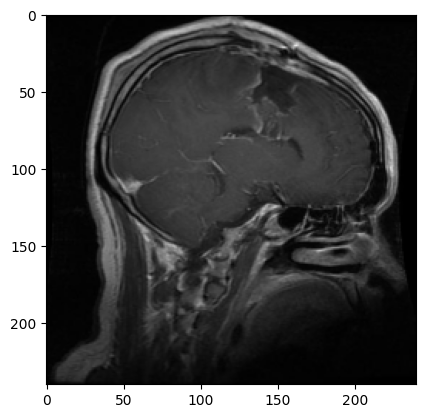

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [7]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 254), (56.23878472222222, 4460.921072134212, '1756.27 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [overlay_image]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 254), (56.23878472222222, 4460.921072134212, '1756.27 %')] 
 [0, '0.17 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


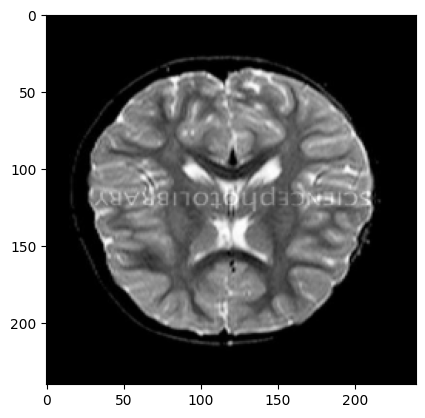

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [56]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 228), (26.397621527777776, 948.6567408706475, '416.08 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [overlay_image]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 228), (26.397621527777776, 948.6567408706475, '416.08 %')] 
 [0, '0.17 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


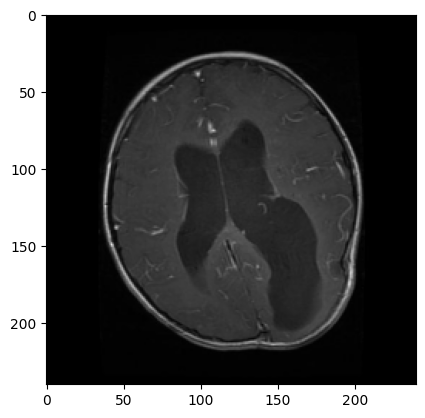

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [21]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 255), (75.60846064814815, 3119.1658983248412, '1223.2 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [overlay_image]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 255), (75.60846064814815, 3119.1658983248412, '1223.2 %')] 
 [0, '0.17 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


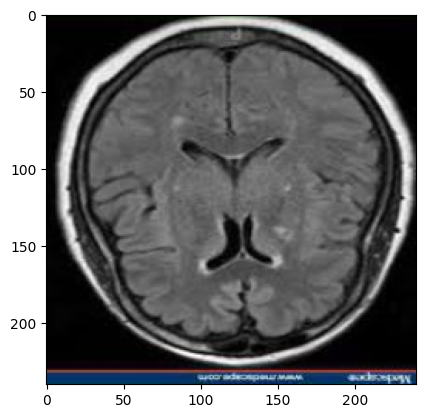

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [16]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 255), (68.7790625, 4657.592193565539, '1826.51 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [overlay_image]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 254), (67.07020833333333, 4453.98097356771, '1753.54 %')] 
 [0, '0.17 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


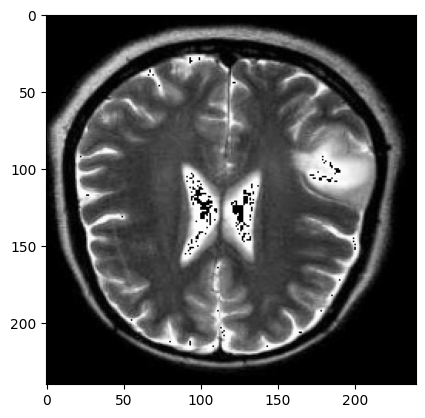

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [58]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 249), (54.389409722222226, 2337.079610068239, '938.59 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [overlay_image]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 249), (54.389409722222226, 2337.079610068239, '938.59 %')] 
 [0, '0.17 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


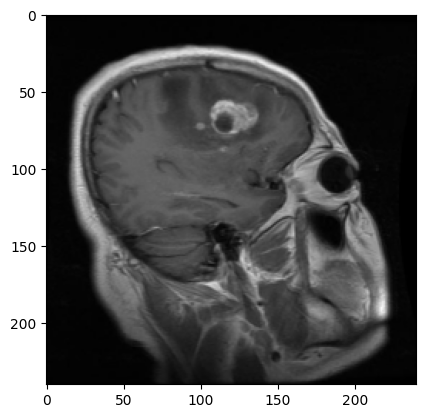

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [59]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 230), (26.288194444444443, 1385.5305897955247, '602.4 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [overlay_image]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 230), (26.288194444444443, 1385.5305897955247, '602.4 %')] 
 [0, '0.17 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


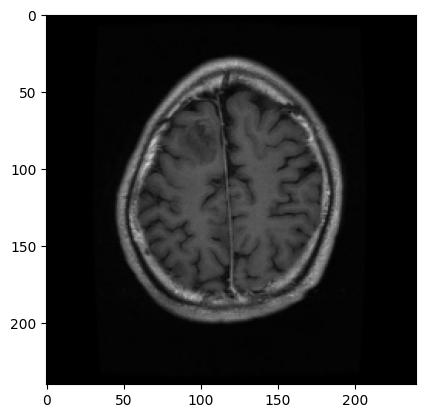

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [33]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 243), (45.41142361111111, 1895.5166681122198, '780.05 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [overlay_image]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 243), (45.41142361111111, 1895.5166681122198, '780.05 %')] 
 [0, '0.17 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


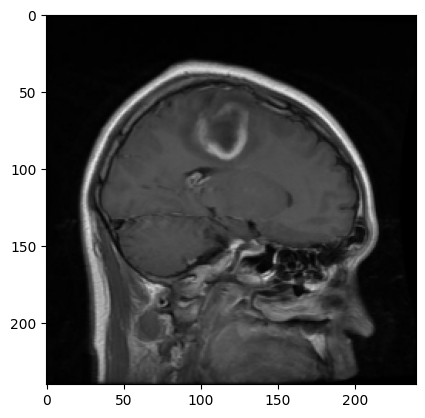

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [35]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 221), (27.71782986111111, 1188.5928626516081, '537.82 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [overlay_image]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 221), (27.71782986111111, 1188.5928626516081, '537.82 %')] 
 [0, '0.17 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


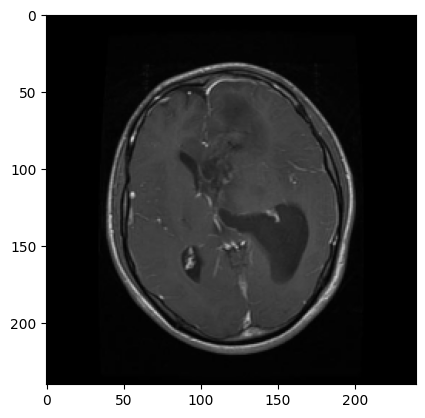

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [61]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 244), (40.12006944444445, 2106.3399930507335, '863.25 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [overlay_image]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 244), (40.12006944444445, 2106.3399930507335, '863.25 %')] 
 [0, '0.17 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


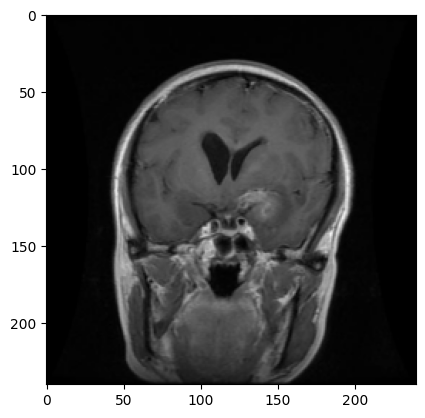

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [32]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 232), (34.928125, 1789.0523339843749, '771.14 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [overlay_image]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 232), (34.928125, 1789.0523339843749, '771.14 %')] 
 [0, '0.17 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


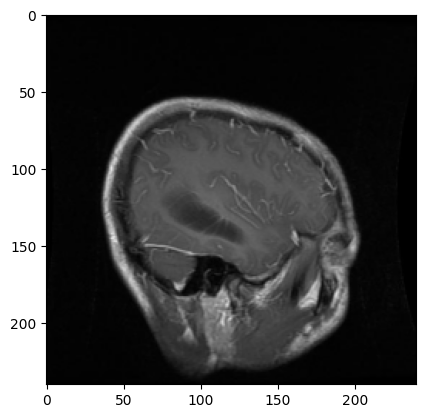

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [26]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 248), (57.07527777777778, 2246.1040902006166, '905.69 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [overlay_image]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 248), (57.07527777777778, 2246.1040902006166, '905.69 %')] 
 [0, '0.17 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


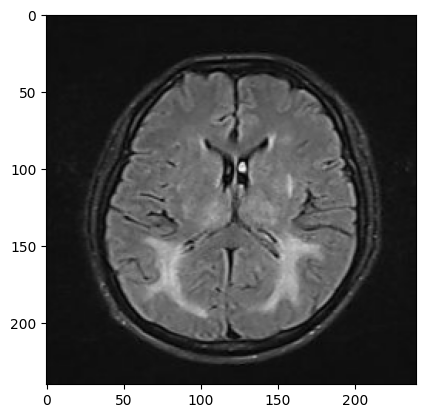

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [22]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 255), (62.596302083333335, 3890.578607853191, '1525.72 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [overlay_image]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 254), (62.43692708333333, 3869.865153751627, '1523.57 %')] 
 [0, '0.17 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


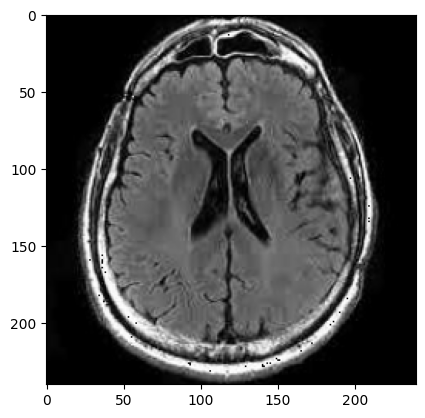

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [20]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 255), (63.238055555555555, 6872.11975316358, '2694.95 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [overlay_image]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 254), (56.52217013888889, 5963.864925151608, '2347.98 %')] 
 [0, '0.17 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


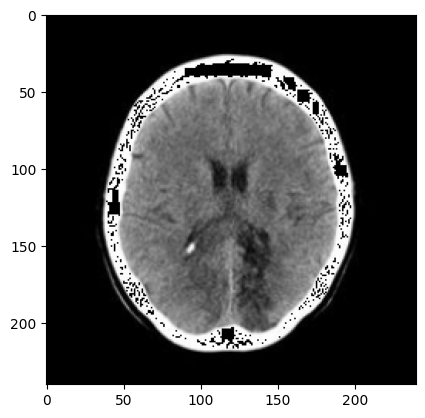

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [10]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 217), (32.13625, 1075.8268178819444, '495.77 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [overlay_image]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 217), (32.13625, 1075.8268178819444, '495.77 %')] 
 [0, '0.17 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


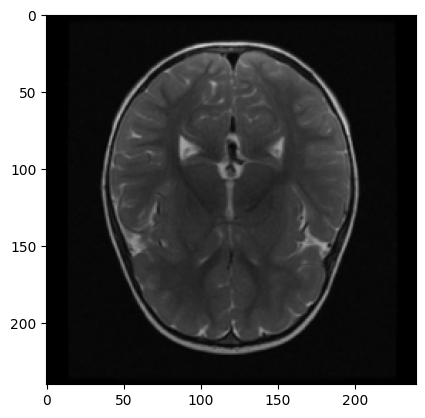

In [14]:
from skimage import color, io
import numpy as np

def get_overlay_color(state):
    if state == "active":
        return (0, 255, 0)  # Green for active
    else:
        return (255, 0, 0)  # Red for inactive (or other state)

def overlay_image(image, state, alpha=0.1):
    """
    Overlay a grayscale image with a colored mask based on state.

    Args:
        image: The image as a NumPy array [RGB]
        state: The state string to determine the overlay color.
        alpha: Transparency level of the overlay (0-1).

    Returns:
        The final image with the colored overlay.
    """
    grayscale_image = color.rgb2gray(image)
    overlay_color = get_overlay_color(state)
    overlay = np.full(image.shape, overlay_color, dtype=np.uint8)

    # Apply transparency
    overlay = (1 - alpha) * image + alpha * overlay

    # Combine grayscale and overlay
    final_image = grayscale_image[..., np.newaxis] * np.ones_like(overlay) + overlay

    return final_image.astype(np.uint8)


if(example_code):
    lis = [x for x in range(64)]
    random.shuffle(lis)
    lis = lis[:15]
    for id in lis:
        image = X[id]
        ut.over(image, str(id))

        # Overlay with desired state and adjust alpha if needed
        final_image = overlay_image(image, "inactive", alpha=0.0)  # Example with 0.7 transparency
        ut.over(final_image, "overlay_image")

        # Display or save the final image (replace with your desired function)
        plt.imshow(final_image)
        plt.show()


## --Network

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models, initializers


# Define the Deep Q Network (DQN) model architecture
def create_dqn_model(input_shape, num_actions=2):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='elu', input_shape=input_shape, kernel_initializer=initializers.glorot_uniform()))
    model.add(layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='elu', kernel_initializer=initializers.glorot_uniform()))
    model.add(layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='elu', kernel_initializer=initializers.glorot_uniform()))
    model.add(layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='elu', kernel_initializer=initializers.glorot_uniform()))

    # Flatten the output volume
    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(512, activation='elu', kernel_initializer=initializers.glorot_uniform()))
    model.add(layers.Dense(256, activation='elu', kernel_initializer=initializers.glorot_uniform()))
    model.add(layers.Dense(128, activation='elu', kernel_initializer=initializers.glorot_uniform()))

    # Output layer
    model.add(layers.Dense(num_actions))  # Assuming num_actions = 3 for 3 actions

    # Compile the model
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=adam_optimizer, loss='mse')  # You can change the optimizer and loss function as needed
    model.summary()
    return model


if(example_code):
    # Create DQN model
    input_shape = (240, 240, 3)  # Define input shape based on your state input
    num_actions = 2  # Number of actions
    dqn_model = create_dqn_model(input_shape, num_actions)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 120, 120, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,686,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,880,034 (14.80 MB)

 Trainable params: 3,880,034 (14.80 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
np.argmax(create_dqn_model((240, 240, 3)).predict(X[0].reshape((1,) + X[0].shape))[0])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 120, 120, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     3,686,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,880,034 (14.80 MB)

 Trainable params: 3,880,034 (14.80 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1716632363.872843     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


0

In [17]:
Y[0]

0

## --Training

In [ ]:
x_arr, y_arr = create_data()

In [ ]:
import numpy as np

# Specify the size of the list
list_size = 10**5

# Generate a random list of integers between 0 and 63
random_list = np.random.randint(0, 64, size=list_size)

print(random_list)
print(len(random_list))


In [ ]:
from collections import deque


# Define a function for TD(0) Q-learning with DQN training in Keras
def td_dqn(num_episodes=300, batch_size=32, target_update=10, gamma=0.99):
    input_shape = (240, 240, 3)
    action_size = 2
    policy_net = create_dqn_model(input_shape, action_size)
    target_net = create_dqn_model(input_shape, action_size)
    target_net.set_weights(policy_net.get_weights())

    replay_memory = deque(maxlen=1500)
    epsilon = 0.7
    decay = 1e-4
    min_epsilon = 1e-4


    for episode in range(num_episodes):
        idx = random_list[episode]
        image, label = x_arr[idx], y_arr[idx]
        state = "inactive"
        done = 0
        while done < 5:
            state_over_image = overlay_image(image, state, alpha=0.1)
            done += 1
            if np.random.rand() < epsilon:
                action = np.random.randint(2)
            else:
                q_values = policy_net.predict(state_over_image.reshape((1,) + X[0].shape))
                action = np.argmax(q_values[0])


            if(label == action):
                next_state = "active"
                reward = 1
            else:
                next_state = "inactive"
                reward = -1


            next_state_over_image = overlay_image(image, next_state, alpha=0.1)
            replay_memory.append((state_over_image, action, reward, next_state_over_image, done==5))
            state = next_state

            if len(replay_memory) >= batch_size:
                minibatch = random.sample(replay_memory, batch_size)
                states, actions, rewards, next_states, dones = zip(*minibatch)

                states = np.array(states)
                actions = np.array(actions)
                rewards = np.array(rewards)
                next_states = np.array(next_states)
                dones = np.array(dones)

                current_q_values = policy_net.predict(states)
                next_q_values = target_net.predict(next_states).max(axis=1)
                target_q_values = rewards + gamma * next_q_values * (1 - dones)

                current_q_values[np.arange(batch_size), actions] = target_q_values

                policy_net.fit(states, current_q_values, verbose=0)


        if episode % target_update == 0: # Target update
            target_net.set_weights(policy_net.get_weights())


        epsilon = max(min_epsilon, epsilon - decay)  # Epsilon decay

    return policy_net

trained_dqn = td_dqn(num_episodes=300, batch_size=32, target_update=10, gamma=0.99)
print(trained_dqn)


In [ ]:
acc = 0
for i in range(64):
    image, label = x_arr[i], y_arr[i]
    state = "inactive"
    state_over_image = overlay_image(image, state, alpha=0.1)
    q_values = trained_dqn.predict(state_over_image.reshape((1,) + X[0].shape))
    action = np.argmax(q_values[0])
    acc += (y_arr[i] == action)
    if(y_arr[i] != action):
        print(i)

print(acc)

In [ ]:
trained_dqn.save("dnq.h5")

In [ ]:
trained_dqn.save("dnq.keras")

In [ ]:
path = '/content/dataset/Testing/notumor/Te-no_0034.jpg'
org_image = io.imread(path)
# Resize image
org_image = ski.transform.resize(org_image, SIZE, anti_aliasing=True)
org_image = retype_image(org_image, 'ubyte')
image = org_image

state = "inactive"
state_over_image = overlay_image(image, state, alpha=0.1)
q_values = trained_dqn.predict(state_over_image.reshape((1,) + X[0].shape))
action = np.argmax(q_values[0])
print(action)

In [ ]:
files = get_random_file_in_folder('/content/dataset/Testing/glioma', 300)
acc = 0
for path in files:
    org_image = io.imread(path)
    # Resize image
    org_image = ski.transform.resize(org_image, SIZE, anti_aliasing=True)
    org_image = retype_image(org_image, 'ubyte')
    image = org_image

    state = "inactive"
    state_over_image = overlay_image(image, state, alpha=0.1)
    q_values = trained_dqn.predict(state_over_image.reshape((1,) + X[0].shape))
    action = np.argmax(q_values[0])
    if(action == 1): acc += 1
print(acc)

In [ ]:
files = get_random_file_in_folder('/content/dataset/Testing/notumor', 300)
acc = 0
for path in files:
    org_image = io.imread(path)
    # Resize image
    org_image = ski.transform.resize(org_image, SIZE, anti_aliasing=True)
    org_image = retype_image(org_image, 'ubyte')
    image = org_image

    state = "inactive"
    state_over_image = overlay_image(image, state, alpha=0.1)
    q_values = trained_dqn.predict(state_over_image.reshape((1,) + X[0].shape))
    action = np.argmax(q_values[0])
    if(action == 0): acc += 1
print(acc)

In [ ]:
tf.keras.models.load_model("dnq.h5")

# Sub Exp2: Curriculum Learning

In [ ]:
def eval_testset(policy_net, test_states, x_test, y_test): 
    actions = policy_net.predict(test_states).argmax(axis=1)
    ut.mess("acc: ", sum(actions == y_test), len(y_test))
    

In [ ]:
from collections import deque


# Define a function for TD(0) Q-learning with DQN training in Keras
def td_dqn(model, x_arr, y_arr, random_list, x_test, y_test,
           num_episodes=300, batch_size=32, target_update=10, gamma=0.99):
    random_list = [x for x in range(len(x_arr))] * 100
    test_states = [] 
    for image in x_test: 
        state = "inactive"
        state_over_image = overlay_image(image, state, alpha=0.1)
        test_states.append(state_over_image)
    test_states = np.array(test_states)
#     ut.over(test_states, "test_states")
#     ut.over(y_test, "y_test")
    
    
    input_shape = (240, 240, 3)
    action_size = 2
    if(model==None): 
        policy_net = create_dqn_model(input_shape, action_size)
    else: 
        policy_net = model
    target_net = create_dqn_model(input_shape, action_size)
    target_net.set_weights(policy_net.get_weights())

    replay_memory = deque(maxlen=1500)
    epsilon = 0.7
    decay = 1e-4
    min_epsilon = 1e-4


    for episode in range(num_episodes):
        idx = random_list[episode]
        image, label = x_arr[idx], y_arr[idx]
        state = "inactive"
        done = 0
        while done < 5:
            state_over_image = overlay_image(image, state, alpha=0.1)
            done += 1
            if np.random.rand() < epsilon:
                action = np.random.randint(2)
            else:
                q_values = policy_net.predict(state_over_image.reshape((1,) + X[0].shape), verbose=0)
                action = np.argmax(q_values[0])


            if(label == action):
                next_state = "active"
                reward = 1
            else:
                next_state = "inactive"
                reward = -1


            next_state_over_image = overlay_image(image, next_state, alpha=0.1)
            replay_memory.append((state_over_image, action, reward, next_state_over_image, done==5))
            state = next_state

            if len(replay_memory) >= batch_size:
                minibatch = random.sample(replay_memory, batch_size)
                states, actions, rewards, next_states, dones = zip(*minibatch)

                states = np.array(states)
                actions = np.array(actions)
                rewards = np.array(rewards)
                next_states = np.array(next_states)
                dones = np.array(dones)

                current_q_values = policy_net.predict(states, verbose=0)
                next_q_values = target_net.predict(next_states, verbose=0).max(axis=1)
                target_q_values = rewards + gamma * next_q_values #!!!
                current_q_values[np.arange(batch_size), actions] = target_q_values

                policy_net.fit(states, current_q_values, verbose=0)


        if episode % target_update == 0: # Target update
            target_net.set_weights(policy_net.get_weights())
            eval_testset(policy_net, test_states, x_test, y_test)
            
        epsilon = max(min_epsilon, epsilon - decay)  # Epsilon decay

    return policy_net

# trained_dqn = td_dqn(num_episodes=300, batch_size=32, target_update=10, gamma=0.99)
# print(trained_dqn)


In [ ]:
x_test, y_test = create_data(num_few=250) 

ut.over(x_test, "x_test")
ut.over(y_test, "y_test")


In [ ]:
import numpy as np

x_arr, y_arr = create_data()
x_arr, y_arr = x_arr[:32], y_arr[:32]
# Specify the size of the list
list_size = 10**5
# Generate a random list of integers between 0 and 63
np.random.seed(42)
random_list = np.random.randint(0, len(x_arr), size=list_size)

print(random_list)
print(len(random_list))


In [ ]:
trained_dqn = None
trained_dqn = td_dqn(trained_dqn, x_arr, y_arr, random_list, x_test, y_test,
    num_episodes=100, batch_size=32, target_update=10, gamma=0.99)

In [ ]:
import numpy as np

x_arr, y_arr = create_data()
x_arr, y_arr = x_arr[32:], y_arr[32:]
# Specify the size of the list
list_size = 10**5
# Generate a random list of integers between 0 and 63
np.random.seed(42)
random_list = np.random.randint(0, len(x_arr), size=list_size)

print(random_list)
print(len(random_list))


In [ ]:
trained_dqn = td_dqn(trained_dqn, x_arr, y_arr, random_list, x_test, y_test,
    num_episodes=50, batch_size=32, target_update=10, gamma=0.99)

In [ ]:
import numpy as np

x_arr, y_arr = create_data()
# x_arr, y_arr = x_arr[], y_arr[]
# Specify the size of the list
list_size = 10**5
# Generate a random list of integers between 0 and 63
# np.random.seed(42)
random_list = np.random.randint(0, len(x_arr), size=list_size)

print(random_list)
print(len(random_list))


In [ ]:
trained_dqn = td_dqn(trained_dqn, x_arr, y_arr, random_list, x_test, y_test,
    num_episodes=1000, batch_size=32, target_update=10, gamma=0.99)

In [ ]:
trained_dqn.save("model_dc.h5")

In [ ]:
test_states = [] 
for image in x_test: 
    state = "inactive"
    state_over_image = overlay_image(image, state, alpha=0.1)
    test_states.append(state_over_image)
test_states = np.array(test_states)

print(test_states.shape)

In [ ]:
eval_testset(trained_dqn, test_states[:250], x_test[:250], y_test[:250])

In [ ]:
eval_testset(trained_dqn, test_states[250:], x_test[250:], y_test[250:])

# Sub Exp3: Localization 

## --Abstract 

In [21]:
import json 
from collections import defaultdict 

with open('/kaggle/input/brain-tumor-detection/Br35H-Mask-RCNN/annotations_all.json', 'r') as file:
    # Load the JSON data from the file
    jfile = json.load(file)
    
    
loc_datadict = defaultdict(list)
print("len of jfile: ", len(jfile))
for key_row in jfile.keys():
    dic = jfile[key_row]
    filename = dic["filename"]
    regions = dic["regions"]
    if(len(regions) > 1): 
        print(filename + ' next!', end=' ')
        continue
    else: 
        region = regions[0]
    if(region["shape_attributes"]["name"] != "polygon"): continue 
    x_list = region["shape_attributes"]["all_points_x"]
    y_list = region["shape_attributes"]["all_points_y"]
    loc_datadict[filename] = (x_list, y_list)

print()
print("len of loc_datadict: ", len(loc_datadict))


len of jfile:  801
y1.jpg next! y6.jpg next! y7.jpg next! y8.jpg next! y11.jpg next! y17.jpg next! y42.jpg next! y59.jpg next! y66.jpg next! y103.jpg next! y112.jpg next! y121.jpg next! y122.jpg next! y130.jpg next! y133.jpg next! y146.jpg next! y157.jpg next! y189.jpg next! y211.jpg next! y212.jpg next! y219.jpg next! y239.jpg next! y241.jpg next! y267.jpg next! y271.jpg next! y283.jpg next! y301.jpg next! y321.jpg next! y325.jpg next! y331.jpg next! y339.jpg next! y346.jpg next! y350.jpg next! y355.jpg next! y362.jpg next! y367.jpg next! y371.jpg next! y388.jpg next! y390.jpg next! y393.jpg next! y394.jpg next! y396.jpg next! y397.jpg next! y404.jpg next! y420.jpg next! y427.jpg next! y434.jpg next! y445.jpg next! y448.jpg next! y450.jpg next! y453.jpg next! y462.jpg next! y463.jpg next! y473.jpg next! y475.jpg next! y477.jpg next! y479.jpg next! y489.jpg next! y495.jpg next! y508.jpg next! y512.jpg next! y513.jpg next! y531.jpg next! y538.jpg next! y539.jpg next! y543.jpg next! y549

In [22]:
yes_list = list(loc_datadict.keys())
yes_list = sorted(yes_list) 
no_list = os.listdir('/kaggle/input/brain-tumor-detection/no')
no_list = sorted(no_list) 

In [23]:
print(len(yes_list), len(no_list))

527 1500


## --Create Loc Data 

In [56]:
import cv2


def create_loc_data(num_few=32, seed=42): 
    X, Y = [], []  
    cnt = 0
    YES_FOLD = '/kaggle/input/brain-tumor-detection/yes/' 
    for filename in yes_list: 
        path = os.path.join(YES_FOLD, filename) 
        org_image = io.imread(path) # x3 
        org_image = retype_image(org_image, 'ubyte') # ubyte 
        
    
        image = org_image.copy()
        x_list, y_list = loc_datadict[filename]
        polygon_points = np.array([[x_list[i], y_list[i]] for i in range(len(x_list))])
        # Draw the polygon on the image
        cv2.polylines(image, [polygon_points], isClosed=True, color=(255, 255, 255), thickness=2)
        # Find the bounding rectangle around the polygon
        x, y, w, h = cv2.boundingRect(polygon_points)
        # Draw the bounding box on the image
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        
        org_image = ski.transform.resize(org_image, (240, 240, 3), anti_aliasing=True) # Resize -> Retype
        org_image = retype_image(org_image, 'ubyte') # Retype (Revalue)
        assert(org_image.all() >= 0 and org_image.all() <= 255) # Retype (Revalue)
        cen = (int(x+w/2), int(y+h/2))
        cen = [cen[0] * 240 / image.shape[0], cen[1] * 240 / image.shape[1]]
        X.append(org_image)
        Y.append(cen)
        
        if(cnt < 2): 
            cnt += 1 
            ut.over(image, "image")
            plt.imshow(image)
            plt.show()
            ut.mess("cen: ", cen)
            ut.over(org_image, "x_image")
            plt.imshow(org_image)
            plt.show()

    X, Y = np.array(X), np.array(Y)
    i, X, ii, Y = train_test_split(X, Y, test_size=num_few, random_state=seed)
    return X, Y 


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <create_loc_data> 
 [image]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (348, 287, 3)] 
 [(0, 255), (89.52193720213064, 8466.61913708589, '3320.24 %')] 
 [0, '0.3 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


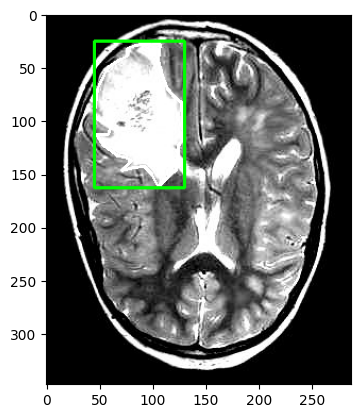

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <create_loc_data>
cen:  [60.0, 78.60627177700349] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <create_loc_data> 
 [x_image]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 255), (89.22006944444445, 7935.920666661845, '3112.13 %')] 
 [0, '0.17 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


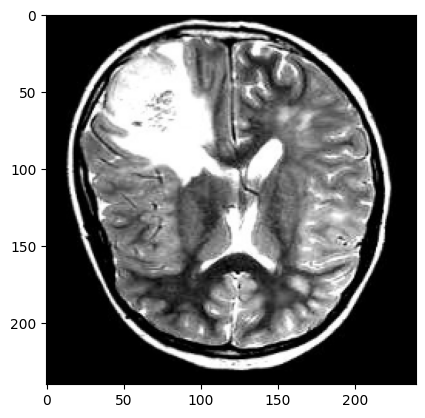

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <create_loc_data> 
 [image]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (879, 766, 3)] 
 [(0, 255), (80.28159224373769, 10969.679002828674, '4301.83 %')] 
 [0, '2.02 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


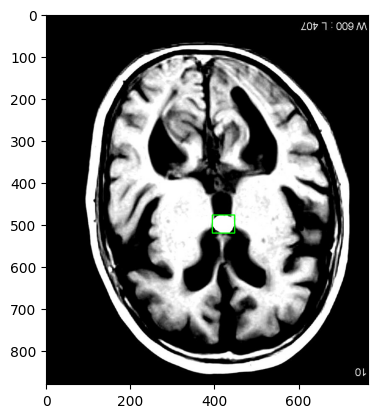

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <create_loc_data>
cen:  [114.67576791808874, 156.0313315926893] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <create_loc_data> 
 [x_image]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 255), (80.24730902777777, 10550.208195883668, '4137.34 %')] 
 [0, '0.17 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


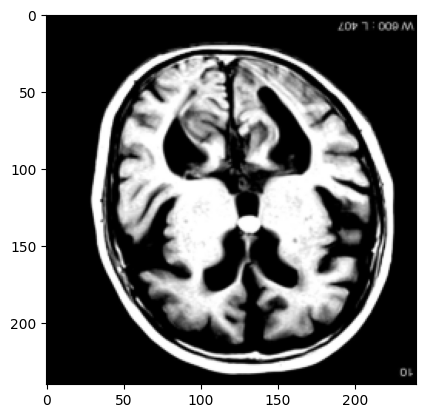

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [X]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (32, 240, 240, 3)] 
 [(0, 255), (83.29230179398148, 6231.151307346423, '2443.59 %')] 
 [0, '5.53 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [Y]
 [(dtype('float64'), <class 'numpy.ndarray'>), (32, 2)] 
 [(43.02521008403362, 217.94117647058823), (116.69734946462282, 1888.044308159899, '1079.4 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [57]:
if(example_code): 
    X, Y = create_loc_data()

    ut.over(X, "X")
    ut.over(Y, "Y")
    

## --LocMDP 

In [153]:
class LocMDP: 
    def __init__(self): 
        pass
    
    def _get_overlay_color(self, state):
        if state == "active":
            return (0, 255, 0)  # Green for active
        else:
            return (255, 0, 0)  # Red for inactive (or other state)

    def overlay_image(self, image, state, alpha=0.1):
        """
        Overlay a grayscale image with a colored mask based on state.
        Args:
            image: The image as a NumPy array [RGB]
            state: The state string to determine the overlay color.
            alpha: Transparency level of the overlay (0-1).
        Returns:
            The final image with the colored overlay.
        """
        gray_image = color.rgb2gray(image)
        overlay_color = self._get_overlay_color(state)
        overlay = np.full(image.shape, overlay_color, dtype=np.uint8)

        # Apply transparency
        overlay = (1 - alpha) * image + alpha * overlay

        # Combine grayscale and overlay
        final_image = gray_image[..., np.newaxis] * np.ones_like(overlay) + overlay
#         ut.over(final_image)

        # Revalue image 
        final_image = final_image.astype(np.uint8) # Negative 
#         ut.over(final_image)
        final_image = np.clip(final_image, 0, 255)
        final_image = revalue_image(final_image, (0, 255), (0, 1))
        return final_image.astype(np.float64)
    
    def overloc_image(self, image, state, alpha=0.1): 
        ni, nj, B = state[0], state[1], 60
        final_image = image.copy()
        tmp = final_image[ni*B: (ni+1)*B, nj*B: (nj+1)*B] 
        tmp = self.overlay_image(tmp, "inactive", alpha=alpha)
        
        final_image = self.overlay_image(final_image, "active", alpha=alpha)
        
        final_image[ni*B: (ni+1)*B, nj*B: (nj+1)*B] = tmp
        return final_image 
    

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>>
 [(dtype('float64'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0.0, 1.0), (0.28719610112563543, 0.0663495765206041, '6.63 %')] 
 [0, '1.38 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


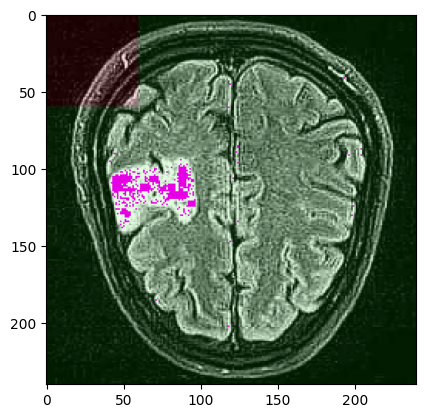

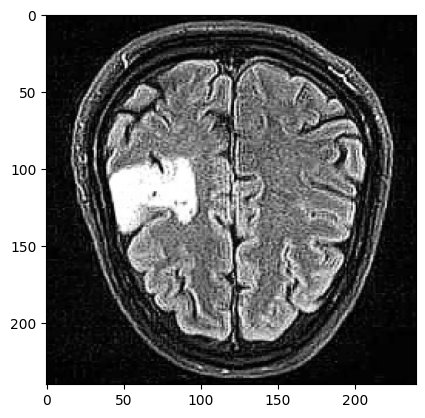

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>>
 [(dtype('float64'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0.0, 1.0), (0.32021693445896887, 0.10322147530619404, '10.32 %')] 
 [0, '1.38 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


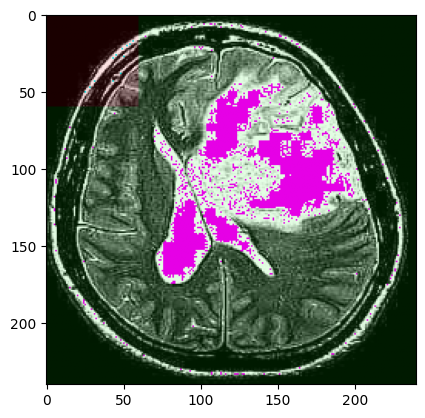

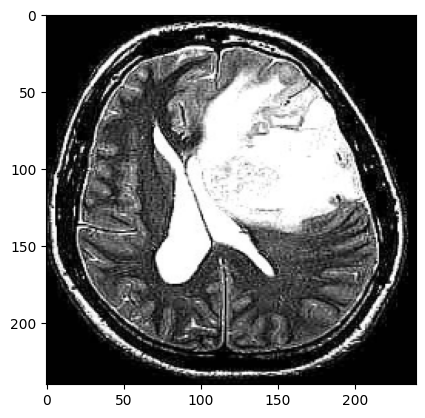

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>>
 [(dtype('float64'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0.0, 1.0), (0.3517824527959332, 0.07745504272404911, '7.75 %')] 
 [0, '1.38 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


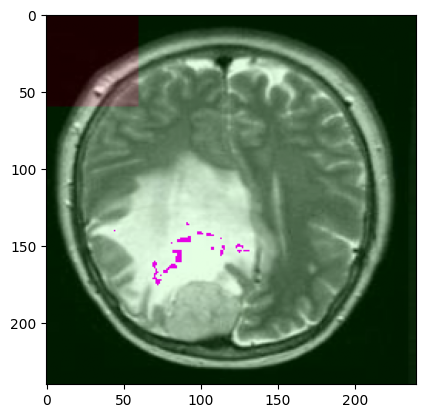

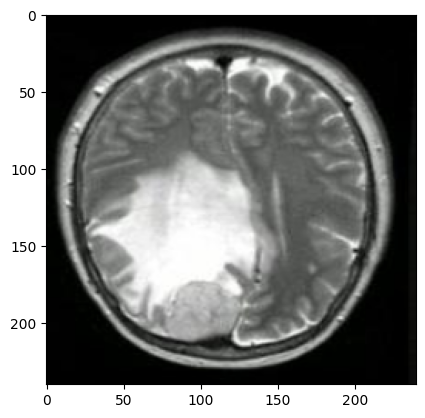

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>>
 [(dtype('float64'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0.0, 1.0), (0.39356846859114014, 0.07900760241428832, '7.9 %')] 
 [0, '1.38 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


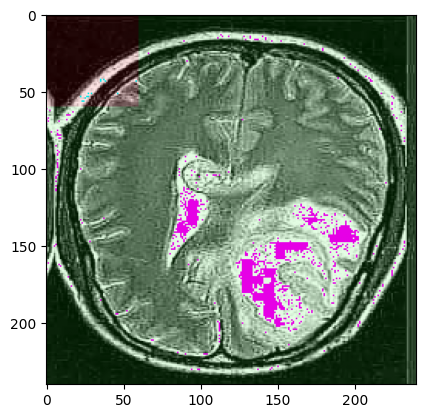

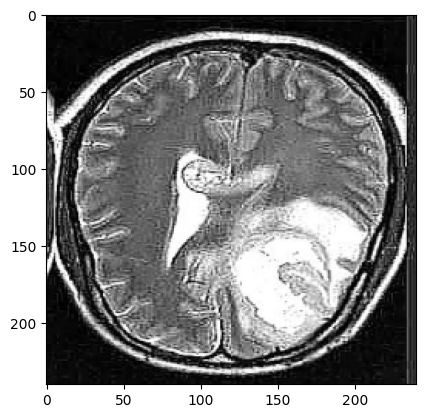

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>>
 [(dtype('float64'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0.0, 1.0), (0.23396089778504, 0.06230632669057623, '6.23 %')] 
 [0, '1.38 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


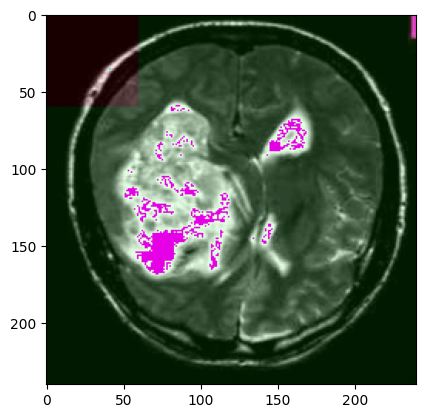

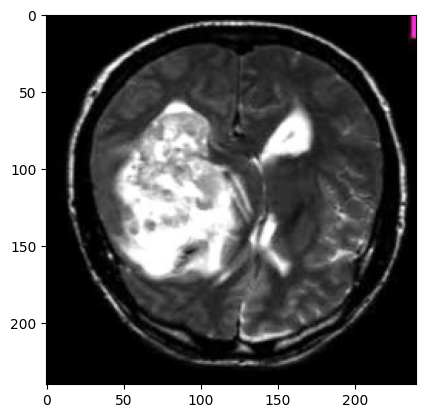

In [154]:
if(example_code): 
    for i in range(5): 
        x = X[i]
        over_image = LocMDP().overloc_image(x, (0, 0), alpha=0.1)

        ut.over(over_image)
        plt.imshow(over_image)
        plt.show()
        plt.imshow(x)
        plt.show()